In [1]:
%matplotlib inline

In [2]:
import data_processor
import data_processor_testfile
import classification
import numpy as np
import matplotlib.pyplot as plt
import plot_roc
import seaborn as sns
import pandas as pd
from sklearn import svm
from sklearn.model_selection import cross_val_score, train_test_split
sns.set(style="ticks", color_codes=True)
plt.rcParams['figure.figsize'] = [20, 14]

TIMEWINDOW = 800  + 1 # 1 second = 128
STEP = 128 
FREQUENCY = 128
TEST_RATE = 0.33

## Load data

In [3]:
df_2016 = data_processor.load_dataframe('data/data2016.mat')
df_2016['shoe'] = df_2016.label == 'shoe'
df_2017 = data_processor.load_dataframe('data/data2017.mat')
df_2017['shoe'] = df_2017.label == 'shoe'
df_2018 = data_processor.load_dataframe('data/data2018.mat')
df_2018['shoe'] = df_2018.label == 'shoe'
df_17_18 = pd.concat((df_2017, df_2018))

df_all = pd.concat((df_2016, df_2017, df_2018))
DATASETS = {"2016": df_2016, "2017": df_2017, "2018": df_2018, "all years merged": df_all}

# Test data
#test_labels, df_test = data_processor_testfile.load_data('data/testData.mat')

# Prepare train and test data
train_data = df_2018.drop(["label", "shoe"], axis=1)
train_labels = df_2018.shoe
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels,
                                                    test_size=TEST_RATE)


## Visualization


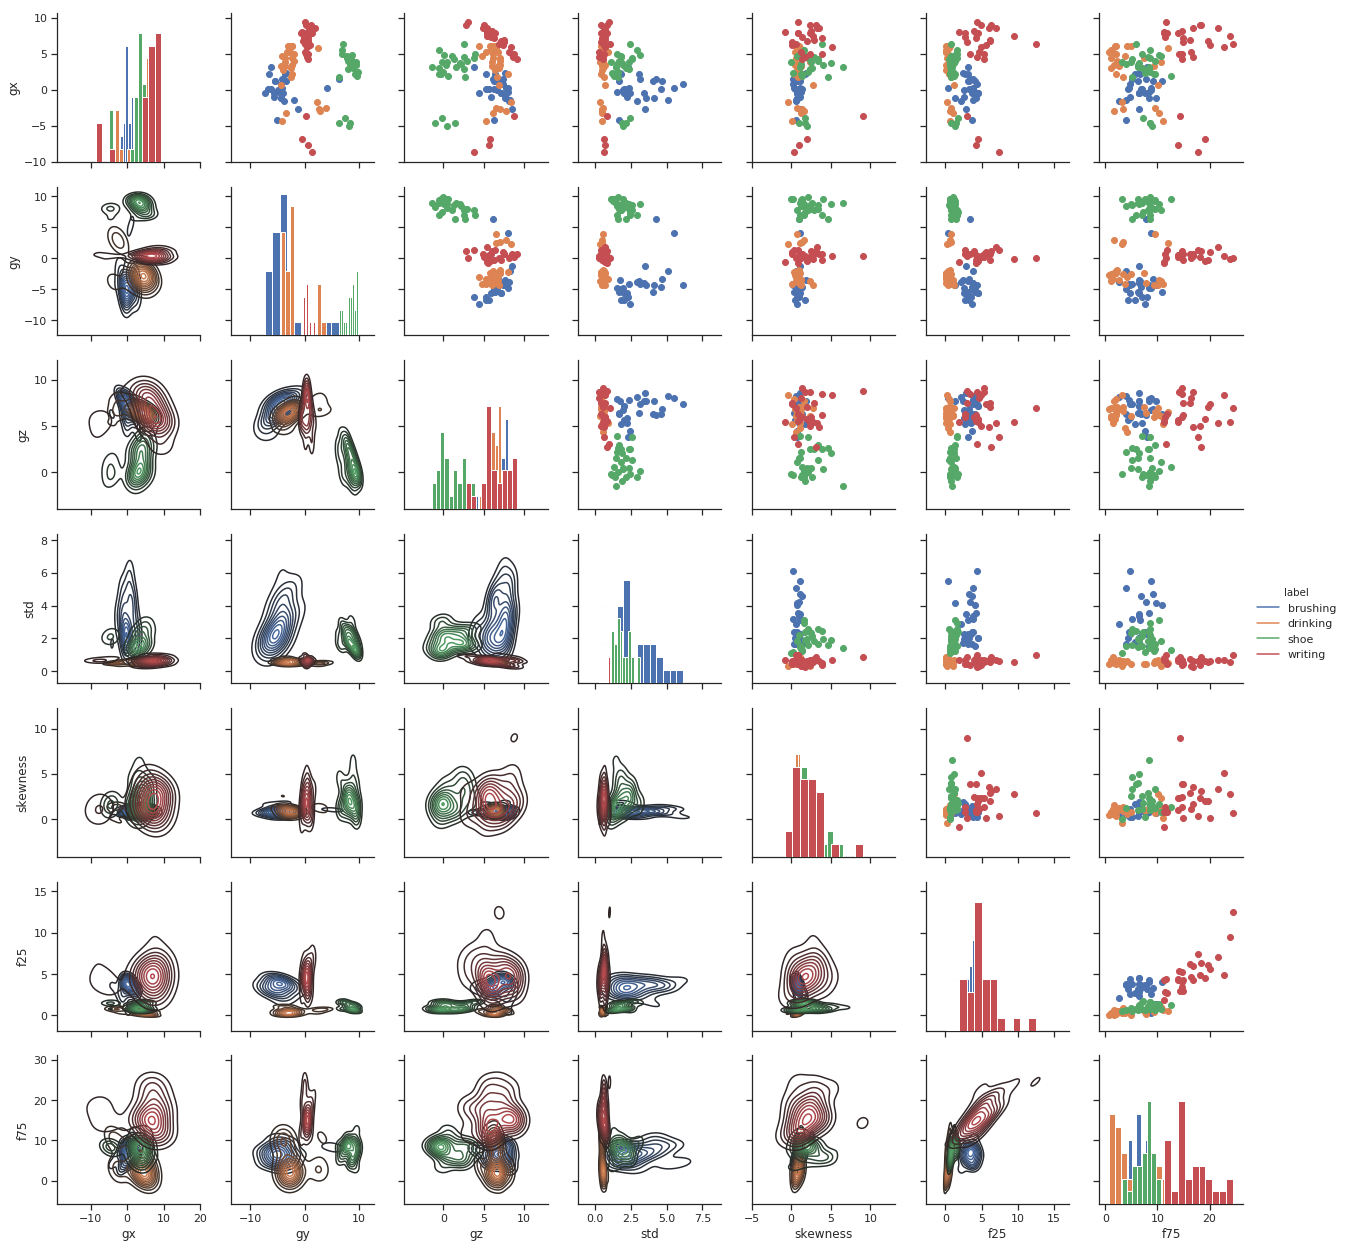

In [4]:
g = sns.PairGrid(df_2018.drop("shoe", axis=1), hue="label")
g = g.map_upper(plt.scatter)
g = g.map_lower(sns.kdeplot)
g = g.map_diag(plt.hist)
g = g.add_legend()
plt.savefig('pairplot.png')

We see that gy and gz are good separators

## Machine learning

## Learn a classifier

Even though a linear classifier works very well on the training data, we realized that a rbf is better on the testing data (gy and gz), so we decided for that option. But we show the separation for the linear case

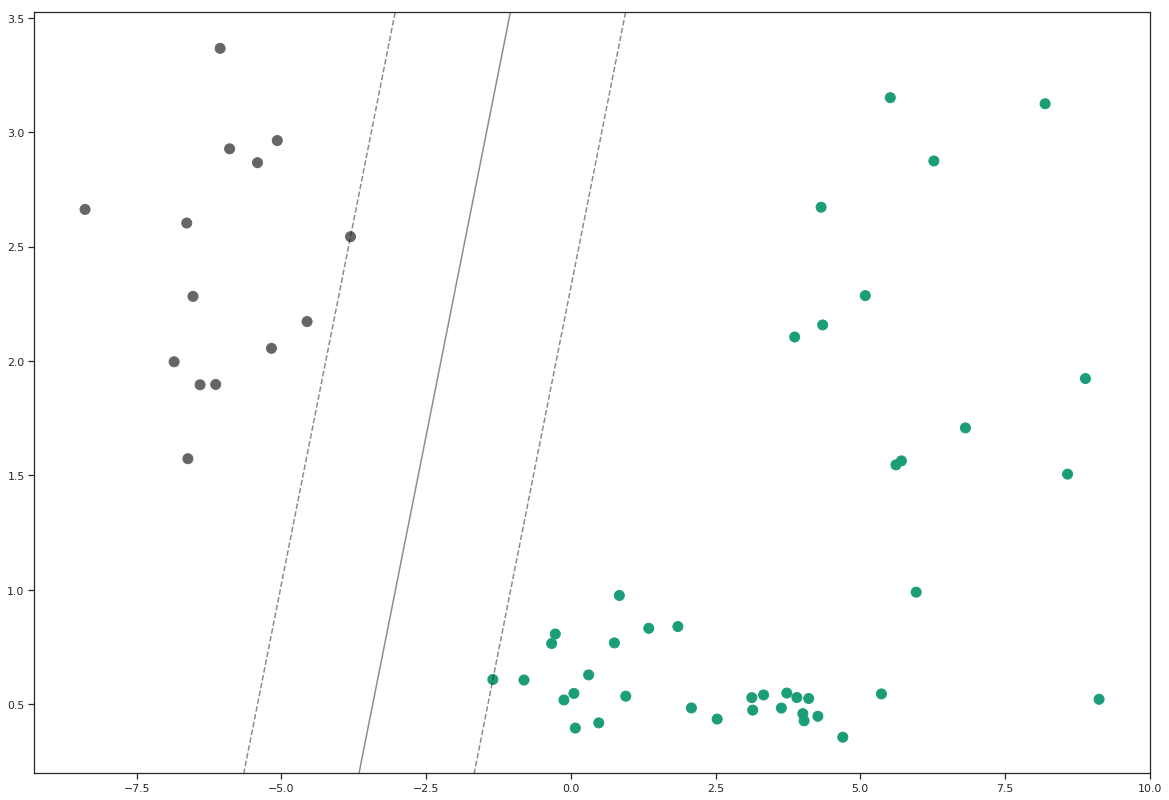

In [5]:
data_linear = df_2017[["gy", "std"]]
label_linear = df_2017.shoe.values
plt.rcParams['figure.figsize'] = [20, 14]

clf_linear = svm.SVC(kernel="linear")
clf_linear.fit(data_linear, label_linear)
classification.plot_svm_boundaries(clf_linear, data_linear.values, label_linear)
#plt.savefig('dec_boundry_linear.pdf')

In [6]:
clf = svm.SVC(kernel="rbf", gamma="scale")
clf.fit(train_data, train_labels)
y_pred = clf.predict(X_test)
print(f"Achieved accuracy for test data: {np.mean(y_pred==y_test)}")

Achieved accuracy for test data: 1.0


# Testing on old data


clf_linear_full = svm.SVC(kernel="linear")
clf_linear_full.fit(train_data, train_labels)


df_17_18 = pd.concat((df_2017, df_2018))
df_17_18[["gy"]] = np.abs(df_17_18[["gy"]])
#clf = svm.SVC(kernel="rbf", gamma="scale")
#clf.fit(df_17_18[["gy", "std"]], df_17_18.shoe.values)

abs2016 = df_2016.copy(deep=True)
abs2016[["gy"]] = np.abs(abs2016[["gy"]])
pred = clf.predict(abs2016[["gy", "std"]])
lbl = df_2016.shoe.values
np.mean(pred == lbl)
classification.plot_confusion_matrix(pred, lbl, ["shoe", "no shoe"])


## Analytics of the training data:

Accuracy: 1.0(+/- 0.0)
Figure(720x504)


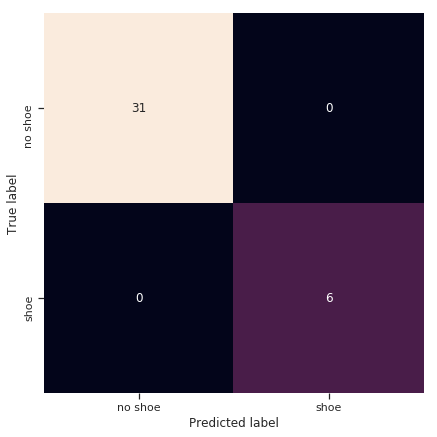

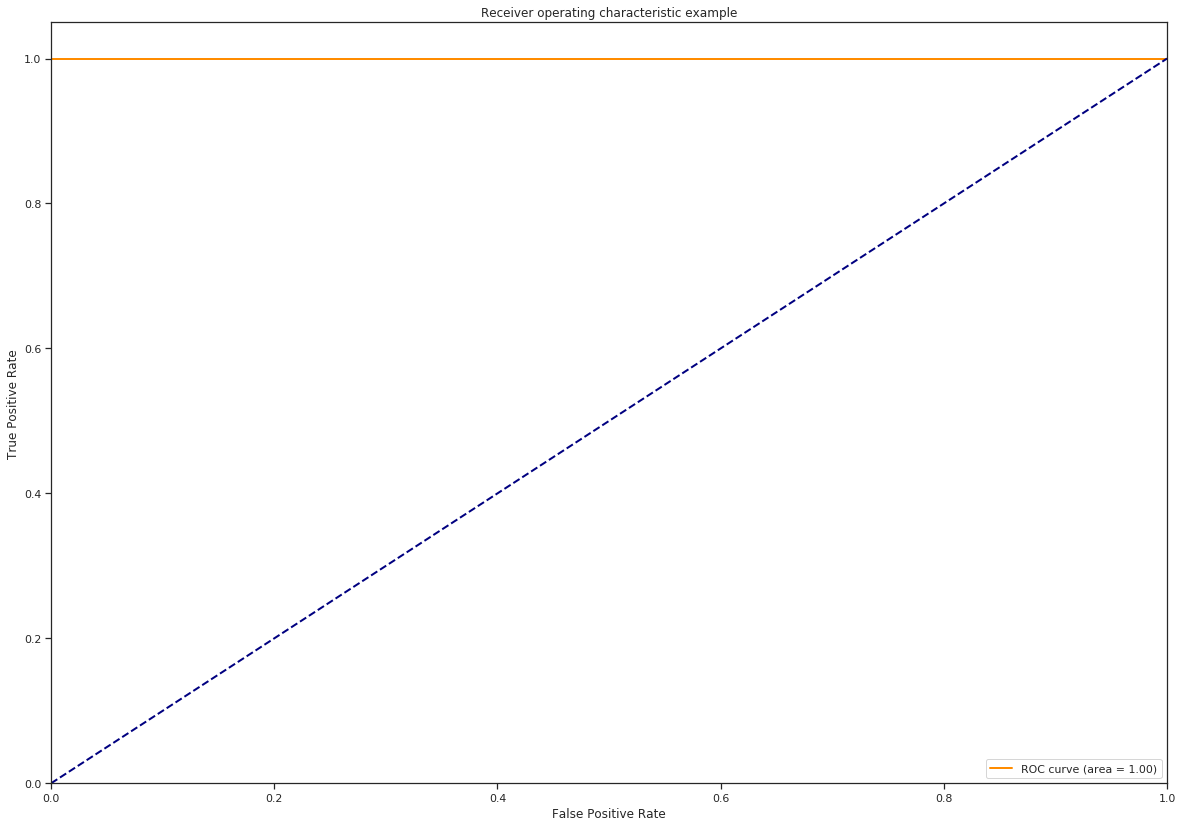

<Figure size 1440x1008 with 0 Axes>

In [7]:
# Cross validation
classification.cross_validation_svm(train_data, train_labels)
classification.plot_confusion_matrix(y_test, y_pred, ["no shoe", "shoe"])
plt.savefig('confusion_train.pdf')
classification.plot_roc_train(clf, train_data, train_labels)
plt.savefig('roc_train.pdf')


# Predict test data

## Visualization and Analytics

In [12]:
pre_lbl17, pre_lbl_window = predict_svm(clf, df_test, len(test_labels), TIMEWINDOW, STEP)

/home/pierre/.virtualenvs/deepl/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/home/pierre/.virtualenvs/deepl/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


In [13]:
pred_lbl_test = np.zeros_like(pre_lbl17)
for i in range(len(pre_lbl17)-801):
    pred_lbl_test[i] = pre_lbl17[i+801]

classification.plot_confusion_matrix(pred_lbl_test, test_labels,["No shoe", "Shoe"], normalize=False)

# Visualization of the Test data windows

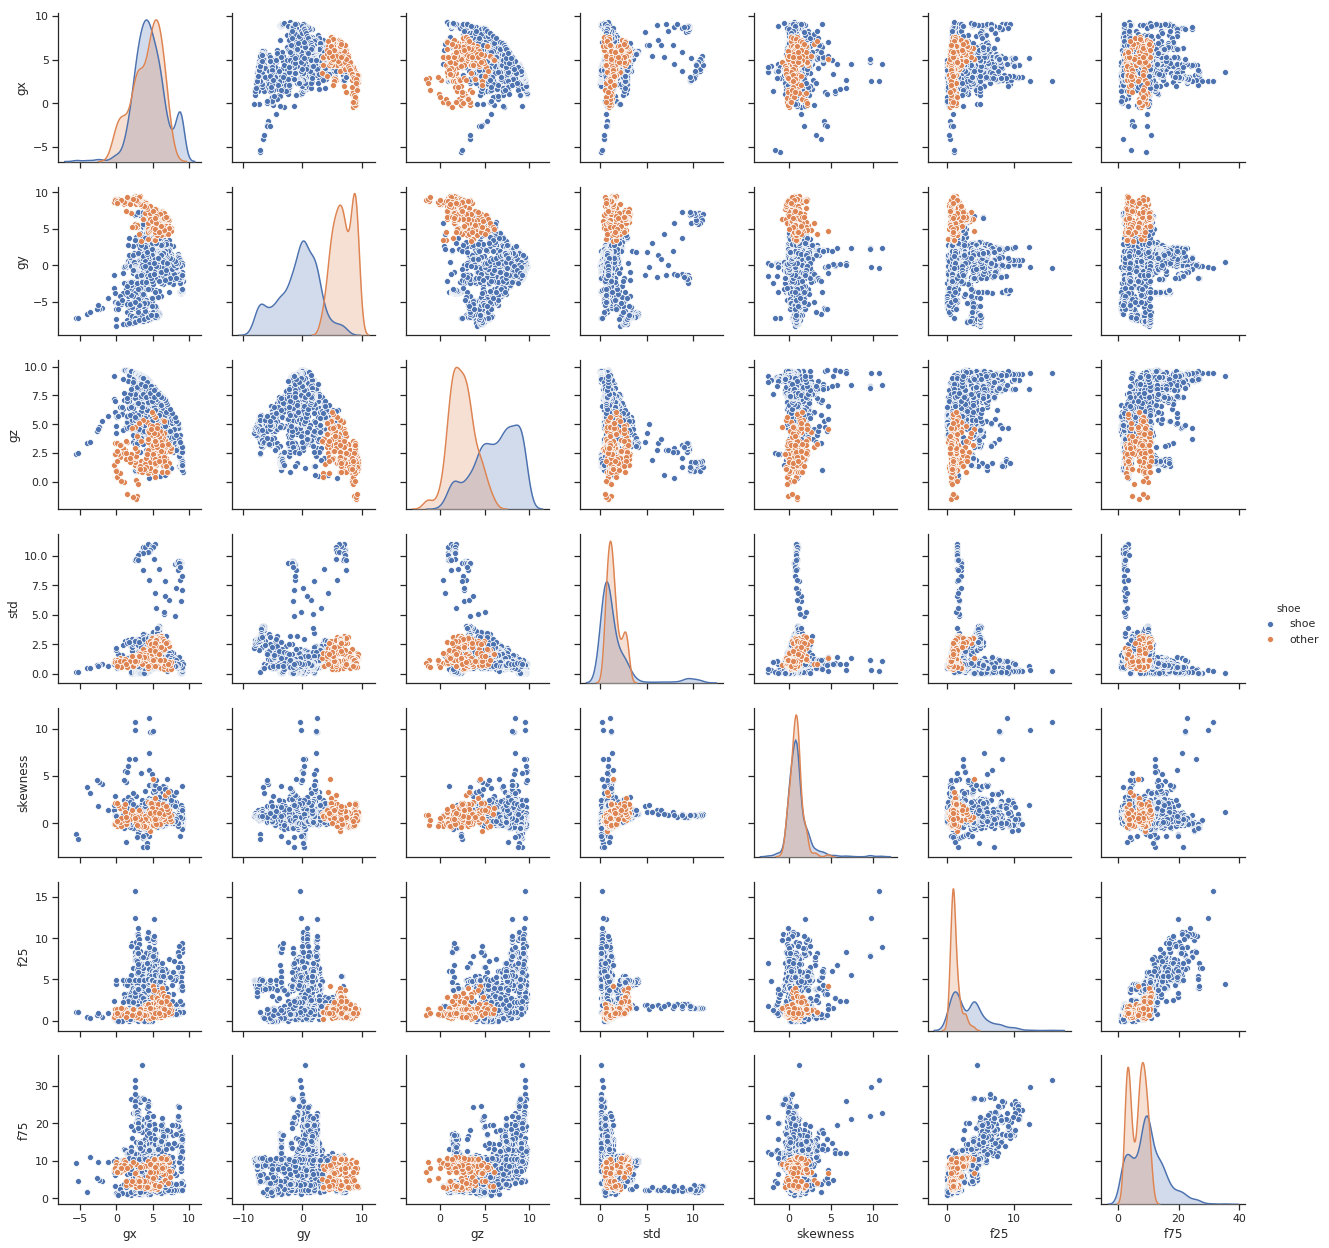

In [23]:
window_lbl = ["shoe" if x==0 else "other" for x in pre_lbl_window]
pred_df = df_test.copy(deep=True)
pred_df["shoe"] = window_lbl
sns.pairplot(pred_df, hue="shoe")
plt.savefig('pairplot_test.png')

# Visualization of the time series

## Visualization of the raw series

In [8]:
df = pd.DataFrame({"True": [1 if x else 0 for x in test_labels], "Prediction": pred_lbl_test})
df.plot()

## Visualization of the predicted series

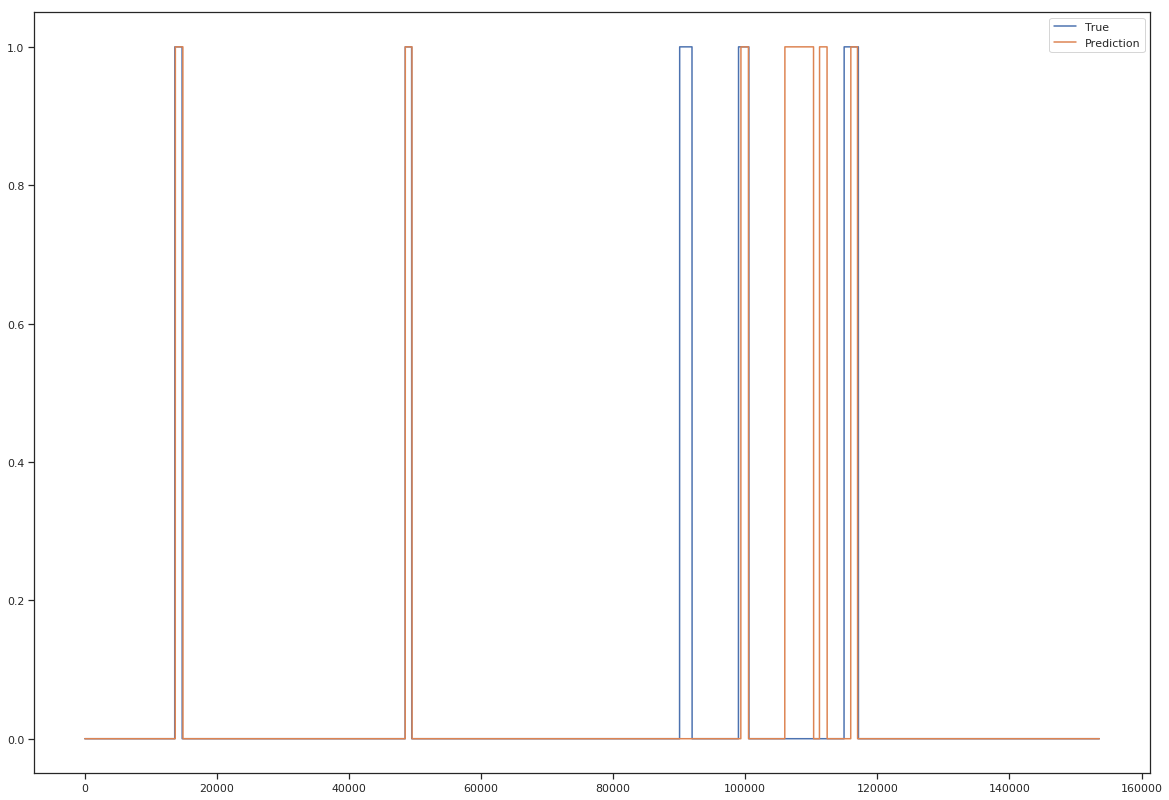

In [21]:
df = pd.DataFrame({"True": [1 if x else 0 for x in test_labels]})
df.plot()